# Trabajo práctico 3 - Organización de datos
## Parte II: Machine Learning Baseline
### Facultad de ingeniería - Universidad de Buenos Aires


---


Alumna: Agustina Bocaccio \\
Padron: 106393 \\
Email: abocaccio@fi.uba.ar \\

---

#### Segundo cuatrimestre 2021
#### Fecha de entrega: 28 de noviembre de 2021


## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold, RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from scipy.stats import uniform

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [ ]:
id='1YGDFxRvxm1wMVaL3E5GpgP2KQqun8OFj'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train_identity.csv')

train_identity  = pd.read_csv('train_identity.csv')

In [ ]:
id='1vAH4o97zYZ2RT8Mbgz3Be4AN2xxbA_4W'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train_transaction.csv')

train_transaction  = pd.read_csv('train_transaction.csv')

In [ ]:
joined = pd.merge(train_transaction, train_identity, how = 'left')
joined

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,debit,272.0,87.0,48.0,NaN,NaN,NaN,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0,2.0,29.0,29.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,204.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,231.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,debit,387.0,87.0,3.0,NaN,aol.com,NaN,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,1.0,1.0,5.0,1.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
del train_transaction
del train_identity

## Funciones auxiliares

In [ ]:
def get_column_types(df, type):
  columns = []
  for column in df:
    if(df[column].dtype==type):
      columns.append(column)
  return columns

In [ ]:
#aplico mean encoding a la columna recibida por parametros y guardo el encoding para esa columna en el diccionario recibido por parametros.

def mean_encoding(df, column, min, mean_encoding_dicts, na_filler):
   df[column].fillna('Unknown', inplace = True)
   dict_amount = df[column].value_counts().to_dict()
   df['amount'] = df[column].map(dict_amount)
   df.loc[df['amount']<min, column]='Other'
   mean_column = df.groupby([column])['isFraud'].mean().to_dict()
   df[column] = df[column].map(mean_column)
   na_filler[column] = mean_column['Unknown']
   mean_encoding_dicts[column] =mean_column
   df.drop(columns=['amount'], inplace=True)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

def plot_roc(_fpr, _tpr, x):

    roc_auc = auc(_fpr, _tpr)

    plt.figure(dpi=100)
    plt.plot(
        _fpr, _tpr, color='darkorange', lw=2, label=f'AUC score: {roc_auc:.2f}'
    )
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    
def graficar_auc_roc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plot_roc(fpr, tpr, thresholds)
    print(f"El valor de la metrica AUC-ROC para este modelo es: {roc_auc_score(y_test, y_pred)}")

## Preparacion del dataset 

Para entrenar agarro las primeras n filas (en este caso tomo un 80%) para usar como train y el otro 20% para validation. Lo hago de esta manera porque tengo a TransactionDT y necesito evitar el time-travelling. TransactionDt ya esta ordenado cronologicamente

In [ ]:
train_set = joined.head(int(len(joined)*0.8)).copy()
validation_set = joined.tail(int(len(joined)*0.2)).copy()

In [ ]:
train_set

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472427,3459427,0,12192667,43.95,W,15484,418.0,150.0,visa,226.0,debit,310.0,87.0,NaN,NaN,hotmail.com,NaN,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,6.0,6.0,2.0,5.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
472428,3459428,0,12192736,49.00,W,17188,321.0,150.0,visa,226.0,debit,220.0,87.0,NaN,NaN,gmail.com,NaN,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
472429,3459429,0,12192742,40.00,H,16659,170.0,150.0,visa,226.0,credit,272.0,87.0,NaN,NaN,gmail.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,34.083332,0.083333,...,0.0,74360.0,0.0,0.0,1.0,0.0,NaN,NaN,1.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,NaN,312.0,597.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_13_3,chrome 65.0,24.0,1440x900,match_status:2,T,F,T,T,desktop,MacOS
472430,3459430,0,12192743,15.00,W,7919,194.0,150.0,mastercard,166.0,debit,220.0,87.0,2.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,382

Encodeo el TransactionDT, que esta en segundos, de manera que quede ciclico usando las funciones seno y coseno.

In [ ]:
seconds_in_day = 24*60*60

train_set['sin_time'] = np.sin(2*np.pi*train_set.TransactionDT/seconds_in_day)
train_set['cos_time'] = np.cos(2*np.pi*train_set.TransactionDT/seconds_in_day)

train_set.drop('TransactionDT', axis=1, inplace=True)

train_set.drop(columns='TransactionID', inplace=True)
train_set

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,...,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,sin_time,cos_time
0,0,68.50,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.432491e-16,1.000000
1,0,29.00,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.272205e-05,1.000000
2,0,59.00,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.017801e-03,0.999987
3,0,50.00,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.199421e-03,0.999974
4,0,50.00,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,7.708461e-03,0.999970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472427,0,43.95,W,15484,418.0,150.0,visa,226.0,debit,310.0,87.0,NaN,NaN,hotmail.com,NaN,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,6.0,6.0,2.0,5.0,2.0,NaN,NaN,NaN,NaN,0.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.791745e-01,0.733977
472428,0,49.00,W,17188,321.0,150.0,visa,226.0,debit,220.0,87.0,NaN,NaN,gmail.com,NaN,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.828489e-01,0.730560
472429,0,40.00,H,16659,170.0,150.0,visa,226.0,credit,272.0,87.0,NaN,NaN,gmail.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,34.083332,0.083333,NaN,NaN,...,0.0,0.0,1.0,0.0,NaN,NaN,1.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,NaN,312.0,597.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_13_3,chrome 65.0,24.0,1440x900,match_status:2,T,F,T,T,desktop,MacOS,6.831676e-01,0.730262
472430,0,15.00,W,7919,194.0,150.0,mastercard,166.0,debit,220.0,87.0,2.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.

In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 472432 entries, 0 to 472431
Columns: 434 entries, isFraud to cos_time
dtypes: float64(401), int64(2), object(31)
memory usage: 1.5+ GB


In [ ]:
categorical_features = get_column_types(train_set, object)
numerical_features = get_column_types(train_set, np.float64)

Ya obtuve las columnas que son objetos, las que tienen menos de 10 categorias las transformo con one hot enoding y las que no las transformo con mean encoding

In [ ]:
encoding_dicts = {}
one_hot_encoding_columns = []
na_filler = {}

for column in categorical_features:
  if(len(train_set[column].value_counts())>10):
    mean_encoding(train_set, column, 500, encoding_dicts, na_filler)
  else:
    one_hot_encoding_columns.append(column)

train_set = pd.get_dummies(train_set, dummy_na=True, drop_first=True, columns=one_hot_encoding_columns)

In [ ]:
train_set

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,M5_T,M5_nan,M6_T,M6_nan,M7_T,M7_nan,M8_T,M8_nan,M9_T,M9_nan,id_12_NotFound,id_12_nan,id_15_New,id_15_Unknown,id_15_nan,id_16_NotFound,id_16_nan,id_23_IP_PROXY:HIDDEN,id_23_IP_PROXY:TRANSPARENT,id_23_nan,id_27_NotFound,id_27_nan,id_28_New,id_28_nan,id_29_NotFound,id_29_nan,id_34_match_status:0,id_34_match_status:1,id_34_match_status:2,id_34_nan,id_35_T,id_35_nan,id_36_T,id_36_nan,id_37_T,id_37_nan,id_38_T,id_38_nan,DeviceType_mobile,DeviceType_nan
0,0,68.50,13926,NaN,150.0,142.0,315.0,87.0,19.0,NaN,0.029829,0.021142,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,...,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
1,0,29.00,2755,404.0,150.0,102.0,325.0,87.0,NaN,NaN,0.044003,0.021142,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,1,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
2,0,59.00,4663,490.0,150.0,166.0,330.0,87.0,287.0,NaN,0.091667,0.021142,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
3,0,50.00,18132,567.0,150.0,117.0,476.0,87.0,NaN,NaN,0.022930,0.021142,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,...,1,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
4,0,50.00,4497,514.0,150.0,102.0,420.0,87.0,NaN,NaN,0.044003,0.021142,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,1,0,1,0,1,0,1,1,0,1,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472427,0,43.95,15484,418.0,150.0,226.0,310.0,87.0,NaN,NaN,0.052021,0.021142,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,6.0,6.0,2.0,5.0,2.0,NaN,NaN,NaN,NaN,0.0,5.0,NaN,NaN,NaN,...,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
472428,0,49.00,17188,321.0,150.0,226.0,220.0,87.0,NaN,NaN,0.044003,0.021142,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,1,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
472429,0,40.00,16659,170.0,150.0,226.0,272.0,87.0,NaN,NaN,0.044003,0.115162,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,34.083332,0.083333,NaN,NaN,NaN,NaN,NaN,...,0,1,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0
472430,0,15.00,7919,194.0,150.0,166.0,220.0,87.0,2.0,NaN,0.044003,0.021142,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,382.0,382.0,7.0,382.0,7.0,NaN,NaN,NaN,NaN,7.0,7.0,NaN,NaN,NaN,...,1,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1


In [ ]:
for column in numerical_features: 
  na_value =  train_set[column].sum()/len(train_set[column])
  na_filler[column] = na_value
  train_set[column].fillna(na_value, inplace=True)

In [ ]:
train_set

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,M5_T,M5_nan,M6_T,M6_nan,M7_T,M7_nan,M8_T,M8_nan,M9_T,M9_nan,id_12_NotFound,id_12_nan,id_15_New,id_15_Unknown,id_15_nan,id_16_NotFound,id_16_nan,id_23_IP_PROXY:HIDDEN,id_23_IP_PROXY:TRANSPARENT,id_23_nan,id_27_NotFound,id_27_nan,id_28_New,id_28_nan,id_29_NotFound,id_29_nan,id_34_match_status:0,id_34_match_status:1,id_34_match_status:2,id_34_nan,id_35_T,id_35_nan,id_36_T,id_36_nan,id_37_T,id_37_nan,id_38_T,id_38_nan,DeviceType_mobile,DeviceType_nan
0,0,68.50,13926,357.465517,150.0,142.0,315.0,87.0,19.000000,16.155927,0.029829,0.021142,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,85.387795,13.000000,95.041225,19.618296,7.9203,2.83434,19.522492,0.073064,13.000000,13.00000,5.85809,1.778008,5.455613,...,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
1,0,29.00,2755,404.000000,150.0,102.0,325.0,87.0,47.631568,16.155927,0.044003,0.021142,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,85.387795,15.446695,0.000000,19.618296,7.9203,2.83434,19.522492,0.073064,0.000000,66.24696,5.85809,1.778008,5.455613,...,1,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
2,0,59.00,4663,490.000000,150.0,166.0,330.0,87.0,287.000000,16.155927,0.091667,0.021142,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,85.387795,15.446695,0.000000,19.618296,7.9203,2.83434,19.522492,0.073064,0.000000,315.00000,5.85809,1.778008,5.455613,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
3,0,50.00,18132,567.000000,150.0,117.0,476.0,87.0,47.631568,16.155927,0.022930,0.021142,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.000000,0.000000,94.000000,0.000000,7.9203,2.83434,19.522492,0.073064,84.000000,66.24696,5.85809,1.778008,5.455613,...,1,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
4,0,50.00,4497,514.000000,150.0,102.0,420.0,87.0,47.631568,16.155927,0.044003,0.021142,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,85.387795,15.446695,95.041225,19.618296,7.9203,2.83434,19.522492,0.073064,101.705384,66.24696,5.85809,1.778008,5.455613,...,0,1,0,1,0,1,0,1,0,1,1,0,1,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472427,0,43.95,15484,418.000000,150.0,226.0,310.0,87.0,47.631568,16.155927,0.052021,0.021142,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,6.0,6.000000,2.000000,5.000000,2.000000,7.9203,2.83434,19.522492,0.073064,0.000000,5.00000,5.85809,1.778008,5.455613,...,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
472428,0,49.00,17188,321.000000,150.0,226.0,220.0,87.0,47.631568,16.155927,0.044003,0.021142,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,85.387795,0.000000,0.000000,19.618296,7.9203,2.83434,19.522492,0.073064,0.000000,0.00000,5.85809,1.778008,5.455613,...,1,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
472429,0,40.00,16659,170.000000,150.0,226.0,272.0,87.0,47.631568,16.155927,0.044003,0.115162,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,85.387795,15.446695,95.041225,19.618296,7.9203,2.83434,34.083332,0.083333,101.705384,66.24696,5.85809,1.778008,5.455613,...,0,1,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0
472430,0,15.00,7919,194.000000,150.0,166.0,220.0,87.0,2.000000,16.155927,0.044003,0.021142,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,382.0,382.000000,7.000000,382.000000,7.000000,7.9203,2.83434,19

Me aseguro que no haya valores nulos en el dataset:

In [ ]:
a = pd.DataFrame({'Cantidad de nulos': train_set.isnull().sum(), 'Porcentaje de nulos': (train_set.isnull().mean() * 100)})
nulos = a.loc[a['Cantidad de nulos']!= 0, :]
nulos

,Cantidad de nulos,Porcentaje de nulos


## Busqueda de hiperparámetros y entrenamiento


In [ ]:
y_train = train_set['isFraud']
train_set.drop(columns=['isFraud'], inplace=True)
X_train = train_set

In [ ]:
X_train

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,...,M5_T,M5_nan,M6_T,M6_nan,M7_T,M7_nan,M8_T,M8_nan,M9_T,M9_nan,id_12_NotFound,id_12_nan,id_15_New,id_15_Unknown,id_15_nan,id_16_NotFound,id_16_nan,id_23_IP_PROXY:HIDDEN,id_23_IP_PROXY:TRANSPARENT,id_23_nan,id_27_NotFound,id_27_nan,id_28_New,id_28_nan,id_29_NotFound,id_29_nan,id_34_match_status:0,id_34_match_status:1,id_34_match_status:2,id_34_nan,id_35_T,id_35_nan,id_36_T,id_36_nan,id_37_T,id_37_nan,id_38_T,id_38_nan,DeviceType_mobile,DeviceType_nan
0,68.50,13926,357.465517,150.0,142.0,315.0,87.0,19.000000,16.155927,0.029829,0.021142,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,85.387795,13.000000,95.041225,19.618296,7.9203,2.83434,19.522492,0.073064,13.000000,13.00000,5.85809,1.778008,5.455613,0.000000,...,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
1,29.00,2755,404.000000,150.0,102.0,325.0,87.0,47.631568,16.155927,0.044003,0.021142,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,85.387795,15.446695,0.000000,19.618296,7.9203,2.83434,19.522492,0.073064,0.000000,66.24696,5.85809,1.778008,5.455613,0.000000,...,1,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
2,59.00,4663,490.000000,150.0,166.0,330.0,87.0,287.000000,16.155927,0.091667,0.021142,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,85.387795,15.446695,0.000000,19.618296,7.9203,2.83434,19.522492,0.073064,0.000000,315.00000,5.85809,1.778008,5.455613,315.000000,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
3,50.00,18132,567.000000,150.0,117.0,476.0,87.0,47.631568,16.155927,0.022930,0.021142,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.000000,0.000000,94.000000,0.000000,7.9203,2.83434,19.522492,0.073064,84.000000,66.24696,5.85809,1.778008,5.455613,111.000000,...,1,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
4,50.00,4497,514.000000,150.0,102.0,420.0,87.0,47.631568,16.155927,0.044003,0.021142,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,85.387795,15.446695,95.041225,19.618296,7.9203,2.83434,19.522492,0.073064,101.705384,66.24696,5.85809,1.778008,5.455613,131.364069,...,0,1,0,1,0,1,0,1,0,1,1,0,1,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472427,43.95,15484,418.000000,150.0,226.0,310.0,87.0,47.631568,16.155927,0.052021,0.021142,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,6.0,6.000000,2.000000,5.000000,2.000000,7.9203,2.83434,19.522492,0.073064,0.000000,5.00000,5.85809,1.778008,5.455613,5.000000,...,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
472428,49.00,17188,321.000000,150.0,226.0,220.0,87.0,47.631568,16.155927,0.044003,0.021142,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,85.387795,0.000000,0.000000,19.618296,7.9203,2.83434,19.522492,0.073064,0.000000,0.00000,5.85809,1.778008,5.455613,0.000000,...,1,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
472429,40.00,16659,170.000000,150.0,226.0,272.0,87.0,47.631568,16.155927,0.044003,0.115162,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,85.387795,15.446695,95.041225,19.618296,7.9203,2.83434,34.083332,0.083333,101.705384,66.24696,5.85809,1.778008,5.455613,131.364069,...,0,1,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0
472430,15.00,7919,194.000000,150.0,166.0,220.0,87.0,2.000000,16.155927,0.044003,0.021142,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,382.0

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 472432 entries, 0 to 472431
Columns: 470 entries, TransactionAmt to DeviceType_nan
dtypes: float64(407), int64(1), uint8(62)
memory usage: 1.5 GB


In [ ]:
# para obtener el modelo entrenado guardado
import pickle 

with open('model_backup', 'rb') as file:
  best_regression, encoding_dicts, one_hot_encoding_columns, na_filler, X_train= pickle.load(file)

In [ ]:
logistic = LogisticRegression(max_iter=1000, random_state=1)
model = LogisticRegression(fit_intercept=True, penalty='l2', tol=1e-5, C=0.8, solver='lbfgs', max_iter=1000, warm_start=True, random_state=1)
distributions = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'])

In [ ]:
best_regression = RandomizedSearchCV(model, distributions, verbose=100, n_iter=5, n_jobs=1, scoring = 'roc_auc', cv=2, random_state=1)
best_regression.fit(X_train.values, y_train.values)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV 1/2; 1/5] START C=1.668088018810296, penalty=l2.............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/2; 1/5] END C=1.668088018810296, penalty=l2;, score=0.751 total time= 3.6min
[CV 2/2; 1/5] START C=1.668088018810296, penalty=l2.............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/2; 1/5] END C=1.668088018810296, penalty=l2;, score=0.744 total time= 3.6min
[CV 1/2; 2/5] START C=3.730229437354635, penalty=l1.............................
[CV 1/2; 2/5] END C=3.730229437354635, penalty=l1;, score=nan total time=   0.7s
[CV 2/2; 2/5] START C=3.730229437354635, penalty=l1.............................
[CV 2/2; 2/5] END C=3.730229437354635, penalty=l1;, score=nan total time=   0.7s
[CV 1/2; 3/5] START C=1.209330290527359, penalty=l1.............................
[CV 1/2; 3/5] END C=1.209330290527359, penalty=l1;, score=nan total time=   0.7s
[CV 2/2; 3/5] START C=1.209330290527359, penalty=l1.............................
[CV 2/2; 3/5] END C=1.209330290527359, penalty=l1;, score=nan total time=   0.7s
[CV 1/2; 4/5] START C=0.9443559078079042, penalty=l1............................
[CV 1/2; 4/5] END C=0.9443559078079042, penalty=l1;, score=nan total time=   0.7s
[CV 2/2; 4/5] START C=0.9443559078079042, penalty=l1............................
[CV 2/2; 4/5] END C=0.944

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
8 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solver l

RandomizedSearchCV(cv=2,
                   estimator=LogisticRegression(C=0.8, max_iter=1000,
                                                random_state=1, tol=1e-05,
                                                warm_start=True),
                   n_iter=5, n_jobs=1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f75a8350450>,
                                        'penalty': ['l2', 'l1']},
                   random_state=1, scoring='roc_auc', verbose=100)

In [ ]:
#para guardar modelo
import pickle
with open('model_backup', 'wb') as model_backup_file:
   pickle.dump(( best_regression, encoding_dicts, one_hot_encoding_columns, na_filler, X_train), model_backup_file)

Metricas para train set:

In [ ]:
roc_auc_score(y_train.values, best_regression.predict_proba(X_train.values)[:,1])

0.7664468917590552

In [ ]:
print(classification_report(y_train.values, best_regression.predict(X_train.values)))  

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    455833
           1       0.64      0.05      0.09     16599

    accuracy                           0.97    472432
   macro avg       0.80      0.52      0.54    472432
weighted avg       0.95      0.97      0.95    472432



## Prediccion para validation

Le aplico el mismo encoding que a train set para realizar las predicciones

In [ ]:
seconds_in_day = 24*60*60

validation_set['sin_time'] = np.sin(2*np.pi*validation_set.TransactionDT/seconds_in_day)
validation_set['cos_time'] = np.cos(2*np.pi*validation_set.TransactionDT/seconds_in_day)

validation_set.drop('TransactionDT', axis=1, inplace=True)

validation_set.drop(columns= 'TransactionID', inplace=True)

for column in encoding_dicts:
  validation_set[column] = validation_set[column].map(encoding_dicts[column])

validation_set = pd.get_dummies(validation_set, dummy_na=True, drop_first=True, columns=one_hot_encoding_columns)

for column in na_filler: 
  validation_set[column].fillna(na_filler[column], inplace=True)

In [ ]:
y_validation = validation_set['isFraud']
X_validation = validation_set.drop(columns=['isFraud'])

In [ ]:
# Puede haber columnas en train_set que no esten en validation set debido al get_dummies, para estos casos genero las columnas necesarias y las pongo en 0
difference = list(set(X_train.columns).difference(set(X_validation.columns)))

for column in difference:
  X_validation[column] = 0

X_validation =  X_validation.reindex(columns=X_train.columns)

Metricas para el **validation set**: 

In [ ]:
roc_auc_score(y_validation.values, best_regression.predict_proba(X_validation.values)[:,1])

0.7596439824682945

In [ ]:
print(classification_report(y_validation.values, best_regression.predict(X_validation.values)))  

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    114044
           1       0.46      0.04      0.07      4064

    accuracy                           0.97    118108
   macro avg       0.71      0.52      0.53    118108
weighted avg       0.95      0.97      0.95    118108



In [ ]:
del validation_set

## Preparacion del test set

In [ ]:
id='1w-hO21eHxYs8NgW_NhXZpckfGuQEL22j'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('test_transaction.csv')

test_transaction = pd.read_csv('test_transaction.csv')

In [ ]:
id='16HGAtDL8NdWSnqE-5WThosY2q0QIoeX-'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('test_identity.csv')

test_identity = pd.read_csv('test_identity.csv')

In [ ]:
test_set = pd.merge(test_transaction, test_identity, how = 'left')

In [ ]:
del test_identity
del test_transaction

In [ ]:
test_set

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.950,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2635.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.950,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.950,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,4170235,34214279,94.679,C,13832,375.0,185.0,mastercard,224.0,debit,284.0,60.0,NaN,NaN,gmail.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
506687,4170236,34214287,12.173,C,3154,408.0,185.0,mastercard,224.0,debit,NaN,NaN,NaN,157.0,hotmail.com,hotmail.com,1.0,3.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,2.0,1.0,1.0,3.0,1.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,NaN,NaN,0.0,...,-45.0,266704.0,NaN,NaN,-3.0,-10.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 43.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,ALE-L23 Build/HuaweiALE-L23
506688,4170237,34214326,49.000,W,16661,490.0,150.0,visa,226.0,debit,327.0,87.0,NaN,NaN,hotmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
506689,4170238,34214337,202.000,W,16621,516.0,150.0,mastercard,224.0,debit,177.0,87.0,NaN,NaN,hotmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,Na

In [ ]:
for columnas in test_set:
  test_set.rename(columns=lambda x: x.replace('id-', 'id_'), inplace = True) 

In [ ]:
difference_1 = list(set(encoding_dicts.keys()).difference(set(test_set.columns))) + list(set(one_hot_encoding_columns).difference(set(test_set.columns))) + list(set(na_filler.keys()).difference(set(test_set.columns)))
for column in difference_1:
  test_set[column] = 0

In [ ]:
transaction_id = test_set.loc[:, ['TransactionID']]
test_set.drop(columns= 'TransactionID', inplace=True)

In [ ]:
seconds_in_day = 24*60*60

test_set['sin_time'] = np.sin(2*np.pi*test_set.TransactionDT/seconds_in_day)
test_set['cos_time'] = np.cos(2*np.pi*test_set.TransactionDT/seconds_in_day)

test_set.drop('TransactionDT', axis=1, inplace=True)

for column in encoding_dicts:
  test_set[column] = test_set[column].map(encoding_dicts[column])

test_set = pd.get_dummies(test_set, dummy_na=True, drop_first=True, columns=one_hot_encoding_columns)

In [ ]:
for column in na_filler: 
  test_set[column].fillna(na_filler[column], inplace=True)

In [ ]:
# Puede haber columnas en train_set que no esten en validation set debido al get_dummies, para estos casos genero las columnas necesarias y las pongo en 0
difference_2 = list(set(X_train.columns).difference(set(test_set.columns)))

for column in difference_2:
  test_set[column] = 0

In [ ]:
test_set =  test_set.reindex(columns=X_train.columns)

In [ ]:
test_set

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,...,M5_T,M5_nan,M6_T,M6_nan,M7_T,M7_nan,M8_T,M8_nan,M9_T,M9_nan,id_12_NotFound,id_12_nan,id_15_New,id_15_Unknown,id_15_nan,id_16_NotFound,id_16_nan,id_23_IP_PROXY:HIDDEN,id_23_IP_PROXY:TRANSPARENT,id_23_nan,id_27_NotFound,id_27_nan,id_28_New,id_28_nan,id_29_NotFound,id_29_nan,id_34_match_status:0,id_34_match_status:1,id_34_match_status:2,id_34_nan,id_35_T,id_35_nan,id_36_T,id_36_nan,id_37_T,id_37_nan,id_38_T,id_38_nan,DeviceType_mobile,DeviceType_nan
0,31.950,10409,111.0,150.0,226.0,170.000000,87.00000,1.000000,16.155927,0.044003,0.021142,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.000000,27.000000,398.0,27.000000,7.9203,2.83434,19.522492,0.073064,418.0,203.00000,5.85809,1.778008,5.455613,409.0,...,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
1,49.000,4272,111.0,150.0,226.0,299.000000,87.00000,4.000000,16.155927,0.021885,0.021142,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.000000,7.000000,634.0,7.000000,7.9203,2.83434,19.522492,0.073064,231.0,634.00000,5.85809,1.778008,5.455613,634.0,...,0,1,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
2,171.000,4476,574.0,150.0,226.0,472.000000,87.00000,2635.000000,16.155927,0.052021,0.021142,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.000000,10.000000,97.0,10.000000,7.9203,2.83434,19.522492,0.073064,136.0,136.00000,5.85809,1.778008,5.455613,97.0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
3,284.950,10989,360.0,150.0,166.0,205.000000,87.00000,17.000000,16.155927,0.044003,0.021142,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.000000,41.000000,242.0,41.000000,7.9203,2.83434,19.522492,0.073064,242.0,242.00000,5.85809,1.778008,5.455613,242.0,...,0,1,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
4,67.950,18018,452.0,150.0,117.0,264.000000,87.00000,6.000000,16.155927,0.044003,0.021142,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.000000,0.000000,22.0,0.000000,7.9203,2.83434,19.522492,0.073064,22.0,22.00000,5.85809,1.778008,5.455613,22.0,...,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,94.679,13832,375.0,185.0,224.0,284.000000,60.00000,47.631568,16.155927,0.044003,0.115162,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,85.387795,15.446695,0.0,19.618296,0.0000,2.83434,19.522492,0.073064,0.0,66.24696,0.00000,1.778008,5.455613,0.0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
506687,12.173,3154,408.0,185.0,224.0,257.416233,76.89818,47.631568,157.000000,0.052021,0.074530,1.0,3.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,2.0,1.0,1.0,3.0,1.0,16.0,16.000000,16.000000,16.0,16.000000,16.0000,16.00000,19.522492,0.073064,0.0,66.24696,16.00000,0.000000,0.000000,16.0,...,0,1,0,1,0,1,0,1,0,1,1,0,1,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
506688,49.000,16661,490.0,150.0,226.0,327.000000,87.00000,47.631568,16.155927,0.052021,0.021142,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,85.387795,15.446695,0.0,19.618296,7.9203,2.83434,19.522492,0.073064,0.0,0.00000,5.85809,1.778008,5.455613,0.0,...,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
506689,202.000,16621,516.0,150.0,224.0,177.000000,87.00000,47.631568,16.155927,0.052021,0.021142,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,85.387795,15.446695,0.0,19.618296,7.9203,2

## Preguntas

#### ¿Cuál es el mejor score de validación obtenido? (¿Cómo conviene obtener el dataset para validar?)


In [ ]:
best_validation_score = roc_auc_score(y_validation.values, best_regression.predict_proba(X_validation.values)[:,1])
best_validation_score 

0.7596439824682945

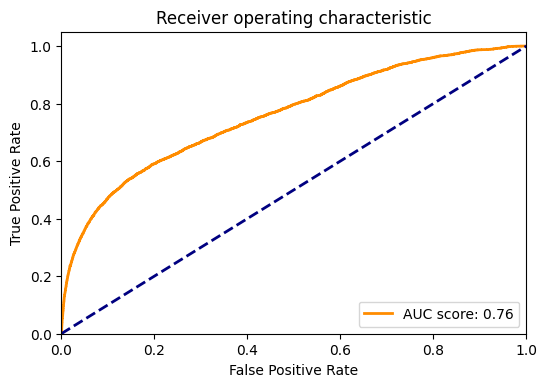

El valor de la metrica AUC-ROC para este modelo es: 0.7596439824682945


In [ ]:
graficar_auc_roc(y_validation.values, best_regression.predict_proba(X_validation.values)[:,1])

Para elegir como obtener el dataset para validar fue importante asegurar que las transacciones fraudulentas sean posteriores a las que se usaron para entrenar el modelo, de esta forma se evita el time-travelling

#### Al predecir con este modelo para la competencia, ¿Cúal es el score obtenido? (guardar el csv con predicciones para entregarlo después)

In [ ]:
predictions_fraud = pd.DataFrame()
predictions_fraud['isFraud'] = best_regression.predict_proba(test_set.values)[:,1]
predictions_fraud['TransactionID']= transaction_id.values
predictions_fraud.to_csv('predictions_fraud.csv', index=False)

In [ ]:
predictions_fraud

,isFraud,TransactionID
0,0.003439,3663549
1,0.008187,3663550
2,0.019142,3663551
3,0.023645,3663552
4,0.041216,3663553
...,...,...
506686,0.017831,4170235
506687,0.099800,4170236
506688,0.016410,4170237
506689,0.019925,4170238


Score obtenido con la regresion logistica: 0.793321

<img src= "https://drive.google.com/uc?id=1pFZxgzO2I3QhG7Mg1Ui4ZtY4WFaPHl77" width="100%">

#### ¿Qué features son los más importantes para predecir con el mejor modelo? Graficar.


Obtengo el valor absoluto de los coeficientes, y me fijo los mayores. Si son negativos es que sirven para predecir los que no son fraude y si son positivos sirven para los que son fraude

In [ ]:
coef = best_regression.best_estimator_.coef_[0]
for i in range(coef.size):
  divisor = X_train.iloc[:, i].mean()
  if(divisor!= 0): 
    coef[i]= coef[i]/divisor

In [ ]:
coef

array([ 2.11017893e-06, -3.40279735e-09, -1.44817847e-06, -3.40886496e-05,
       -3.43937148e-05, -3.55382131e-06, -5.30716373e-05,  1.71890802e-06,
       -3.54190155e-06, -1.58661054e-05,  1.62844803e-04,  6.08546823e-05,
        1.57050574e-04, -7.03530787e-04, -4.06975563e-05, -8.68118765e-05,
       -6.49417146e-05, -1.57942718e-04,  3.66242628e-06, -7.44823102e-05,
       -1.18111120e-04,  1.14334428e-05,  6.94429340e-06, -1.02466856e-04,
       -1.46528063e-04, -3.18745083e-07, -2.75716509e-05, -9.23664183e-05,
       -2.51584177e-06, -1.26513821e-04,  1.99114857e-05, -1.67868592e-04,
       -9.59057344e-05,  1.87965320e-04,  8.43781046e-07, -1.10652236e-05,
        9.62363714e-05, -1.06593569e-04,  9.04299181e-05, -3.22977278e-06,
       -7.64282858e-05, -7.35290950e-05, -5.94715745e-05, -7.23114473e-05,
       -5.30367406e-05, -7.69666953e-05, -7.10185665e-05, -7.43172160e-05,
       -6.67570669e-05, -1.77822978e-04, -1.78554011e-04, -6.26116020e-05,
       -4.44230696e-05, -

In [ ]:
X_train

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,...,M5_T,M5_nan,M6_T,M6_nan,M7_T,M7_nan,M8_T,M8_nan,M9_T,M9_nan,id_12_NotFound,id_12_nan,id_15_New,id_15_Unknown,id_15_nan,id_16_NotFound,id_16_nan,id_23_IP_PROXY:HIDDEN,id_23_IP_PROXY:TRANSPARENT,id_23_nan,id_27_NotFound,id_27_nan,id_28_New,id_28_nan,id_29_NotFound,id_29_nan,id_34_match_status:0,id_34_match_status:1,id_34_match_status:2,id_34_nan,id_35_T,id_35_nan,id_36_T,id_36_nan,id_37_T,id_37_nan,id_38_T,id_38_nan,DeviceType_mobile,DeviceType_nan
0,68.50,13926,357.465517,150.0,142.0,315.0,87.0,19.000000,16.155927,0.029829,0.021142,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,85.387795,13.000000,95.041225,19.618296,7.9203,2.83434,19.522492,0.073064,13.000000,13.00000,5.85809,1.778008,5.455613,0.000000,...,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
1,29.00,2755,404.000000,150.0,102.0,325.0,87.0,47.631568,16.155927,0.044003,0.021142,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,85.387795,15.446695,0.000000,19.618296,7.9203,2.83434,19.522492,0.073064,0.000000,66.24696,5.85809,1.778008,5.455613,0.000000,...,1,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
2,59.00,4663,490.000000,150.0,166.0,330.0,87.0,287.000000,16.155927,0.091667,0.021142,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,85.387795,15.446695,0.000000,19.618296,7.9203,2.83434,19.522492,0.073064,0.000000,315.00000,5.85809,1.778008,5.455613,315.000000,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
3,50.00,18132,567.000000,150.0,117.0,476.0,87.0,47.631568,16.155927,0.022930,0.021142,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.000000,0.000000,94.000000,0.000000,7.9203,2.83434,19.522492,0.073064,84.000000,66.24696,5.85809,1.778008,5.455613,111.000000,...,1,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
4,50.00,4497,514.000000,150.0,102.0,420.0,87.0,47.631568,16.155927,0.044003,0.021142,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,85.387795,15.446695,95.041225,19.618296,7.9203,2.83434,19.522492,0.073064,101.705384,66.24696,5.85809,1.778008,5.455613,131.364069,...,0,1,0,1,0,1,0,1,0,1,1,0,1,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472427,43.95,15484,418.000000,150.0,226.0,310.0,87.0,47.631568,16.155927,0.052021,0.021142,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,6.0,6.000000,2.000000,5.000000,2.000000,7.9203,2.83434,19.522492,0.073064,0.000000,5.00000,5.85809,1.778008,5.455613,5.000000,...,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
472428,49.00,17188,321.000000,150.0,226.0,220.0,87.0,47.631568,16.155927,0.044003,0.021142,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,85.387795,0.000000,0.000000,19.618296,7.9203,2.83434,19.522492,0.073064,0.000000,0.00000,5.85809,1.778008,5.455613,0.000000,...,1,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
472429,40.00,16659,170.000000,150.0,226.0,272.0,87.0,47.631568,16.155927,0.044003,0.115162,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,85.387795,15.446695,95.041225,19.618296,7.9203,2.83434,34.083332,0.083333,101.705384,66.24696,5.85809,1.778008,5.455613,131.364069,...,0,1,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0
472430,15.00,7919,194.000000,150.0,166.0,220.0,87.0,2.000000,16.155927,0.044003,0.021142,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,382.0

In [ ]:
coef_abs = np.absolute(coef)
max_index = (-coef_abs).argsort()[:10]
columns = []
scores = []
for i in max_index:
  columns.append(str(X_train.columns[i]))
  scores.append(best_regression.best_estimator_.coef_[0][i])
  print("Feature: " + str(X_train.columns[i]) + ", Score: " + str( best_regression.best_estimator_.coef_[0][i]))

features_score = pd.Series(scores, columns)

Feature: id_04, Score: 0.001988696536775214
Feature: V232, Score: 0.0018773405049072602
Feature: V233, Score: 0.0018126202700433317
Feature: V147, Score: 0.001644794550850485
Feature: V231, Score: 0.0015927006891751768
Feature: V177, Score: 0.001336613492361177
Feature: V239, Score: 0.0012834655752223508
Feature: V219, Score: 0.001273941388561104
Feature: V146, Score: 0.00119115117281683
Feature: V217, Score: 0.001173798183964186


Text(0, 0.5, 'Score')

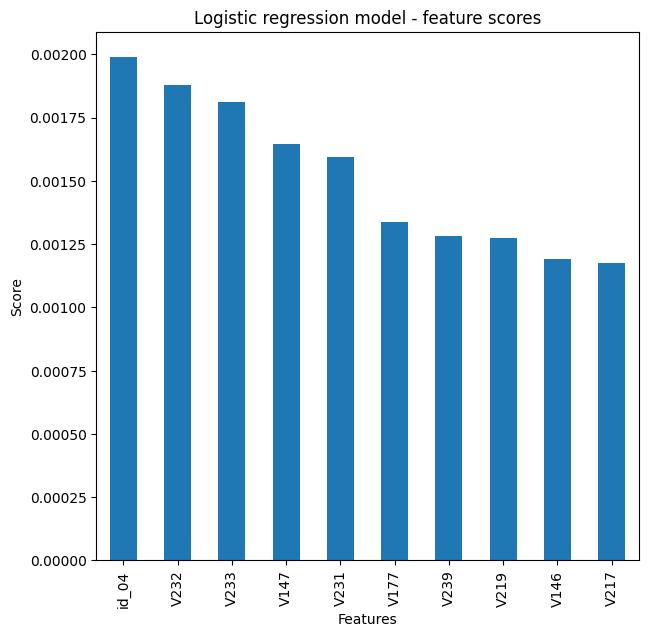

In [ ]:
plt.figure(figsize=(7,7), dpi=100)
features_score.plot.bar()
plt.title('Logistic regression model - feature scores')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.ylabel('Score')